# Credit Card Detection 

## Load relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from imblearn.under_sampling import TomekLinks, NearMiss
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df = pd.read_csv('card_transdata.csv')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
df.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [5]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

In [6]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


<hr>

## EDA

### Target Feature

Text(0, 0.5, 'Count')

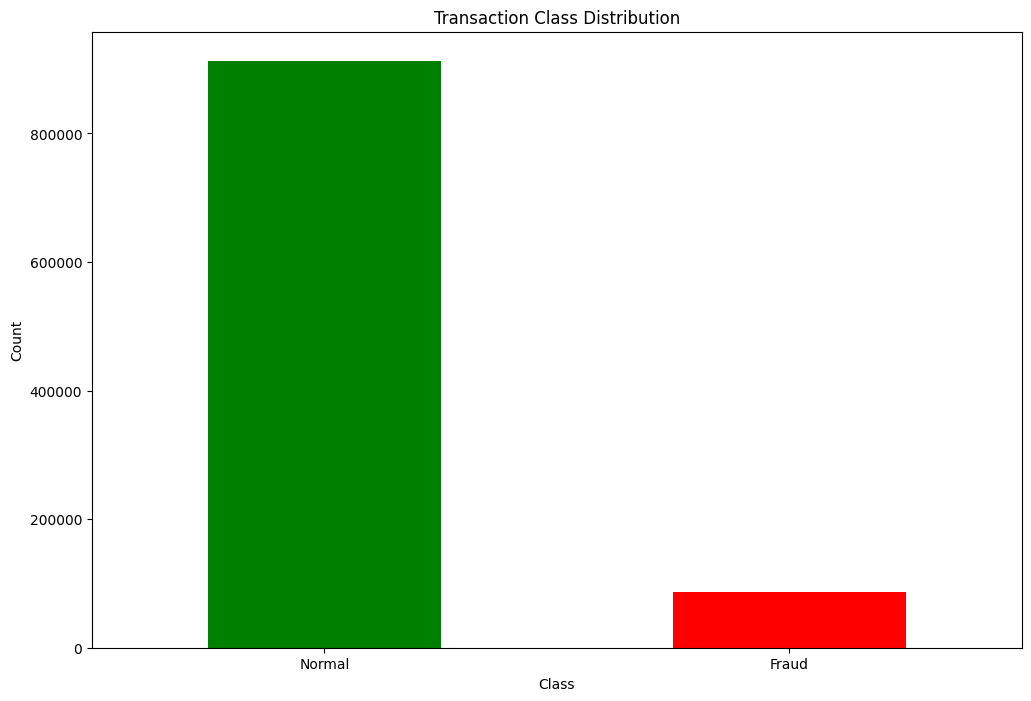

In [7]:
labels= ["Normal", "Fraud"]

plt.figure(figsize=(12,8))
pd.value_counts(df['fraud'], sort=True).plot(kind='bar', rot=0, color=['green', 'red'])
plt.title("Transaction Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Count")

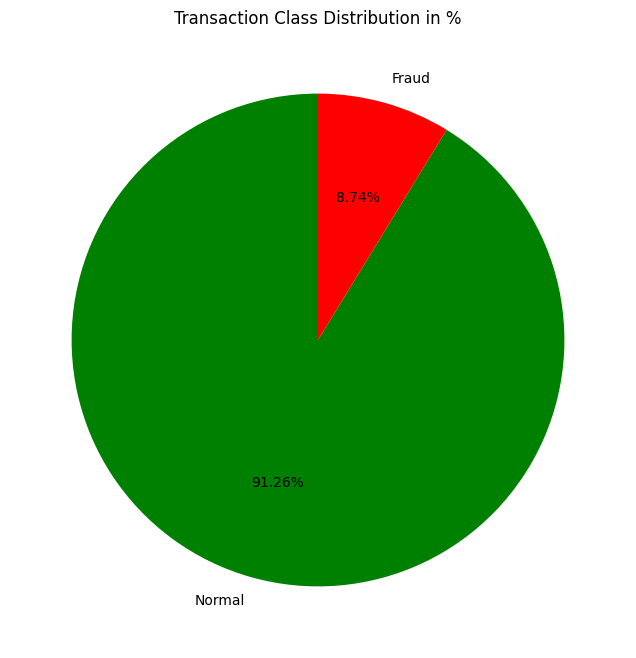

In [8]:
pie_values = [pd.value_counts(df['fraud'], sort=True)[0] / sum(pd.value_counts(df['fraud'], sort=True)) * 100, pd.value_counts(df['fraud'], sort=True)[1] / sum(pd.value_counts(df['fraud'], sort=True)) * 100]

plt.figure(figsize=(12,8))
plt.pie(pie_values, labels=['Normal', 'Fraud'],
        autopct = '%1.2f%%',       
        startangle = 90,
        colors=['Green', 'Red'])
plt.title('Transaction Class Distribution in %')
plt.show()

The data in our credit card fraud dataset is imbalanced, with 91.26% of transactions being classified as normal and only 8.74% as fraudulent. As a result, a naive model that always predicts the majority class would achieve an accuracy of 91.26%, but would perform poorly at detecting fraudulent transactions. To address this issue, we may consider taking advantage of either undersampling or oversampling techniques to rebalance the dataset and improve our model's ability to detect fraud.

### Outlier

In [9]:
columns = (list(df.loc[:, 'distance_from_home':'fraud']))

Text(0.5, 1.0, 'Boxplot for each feature')

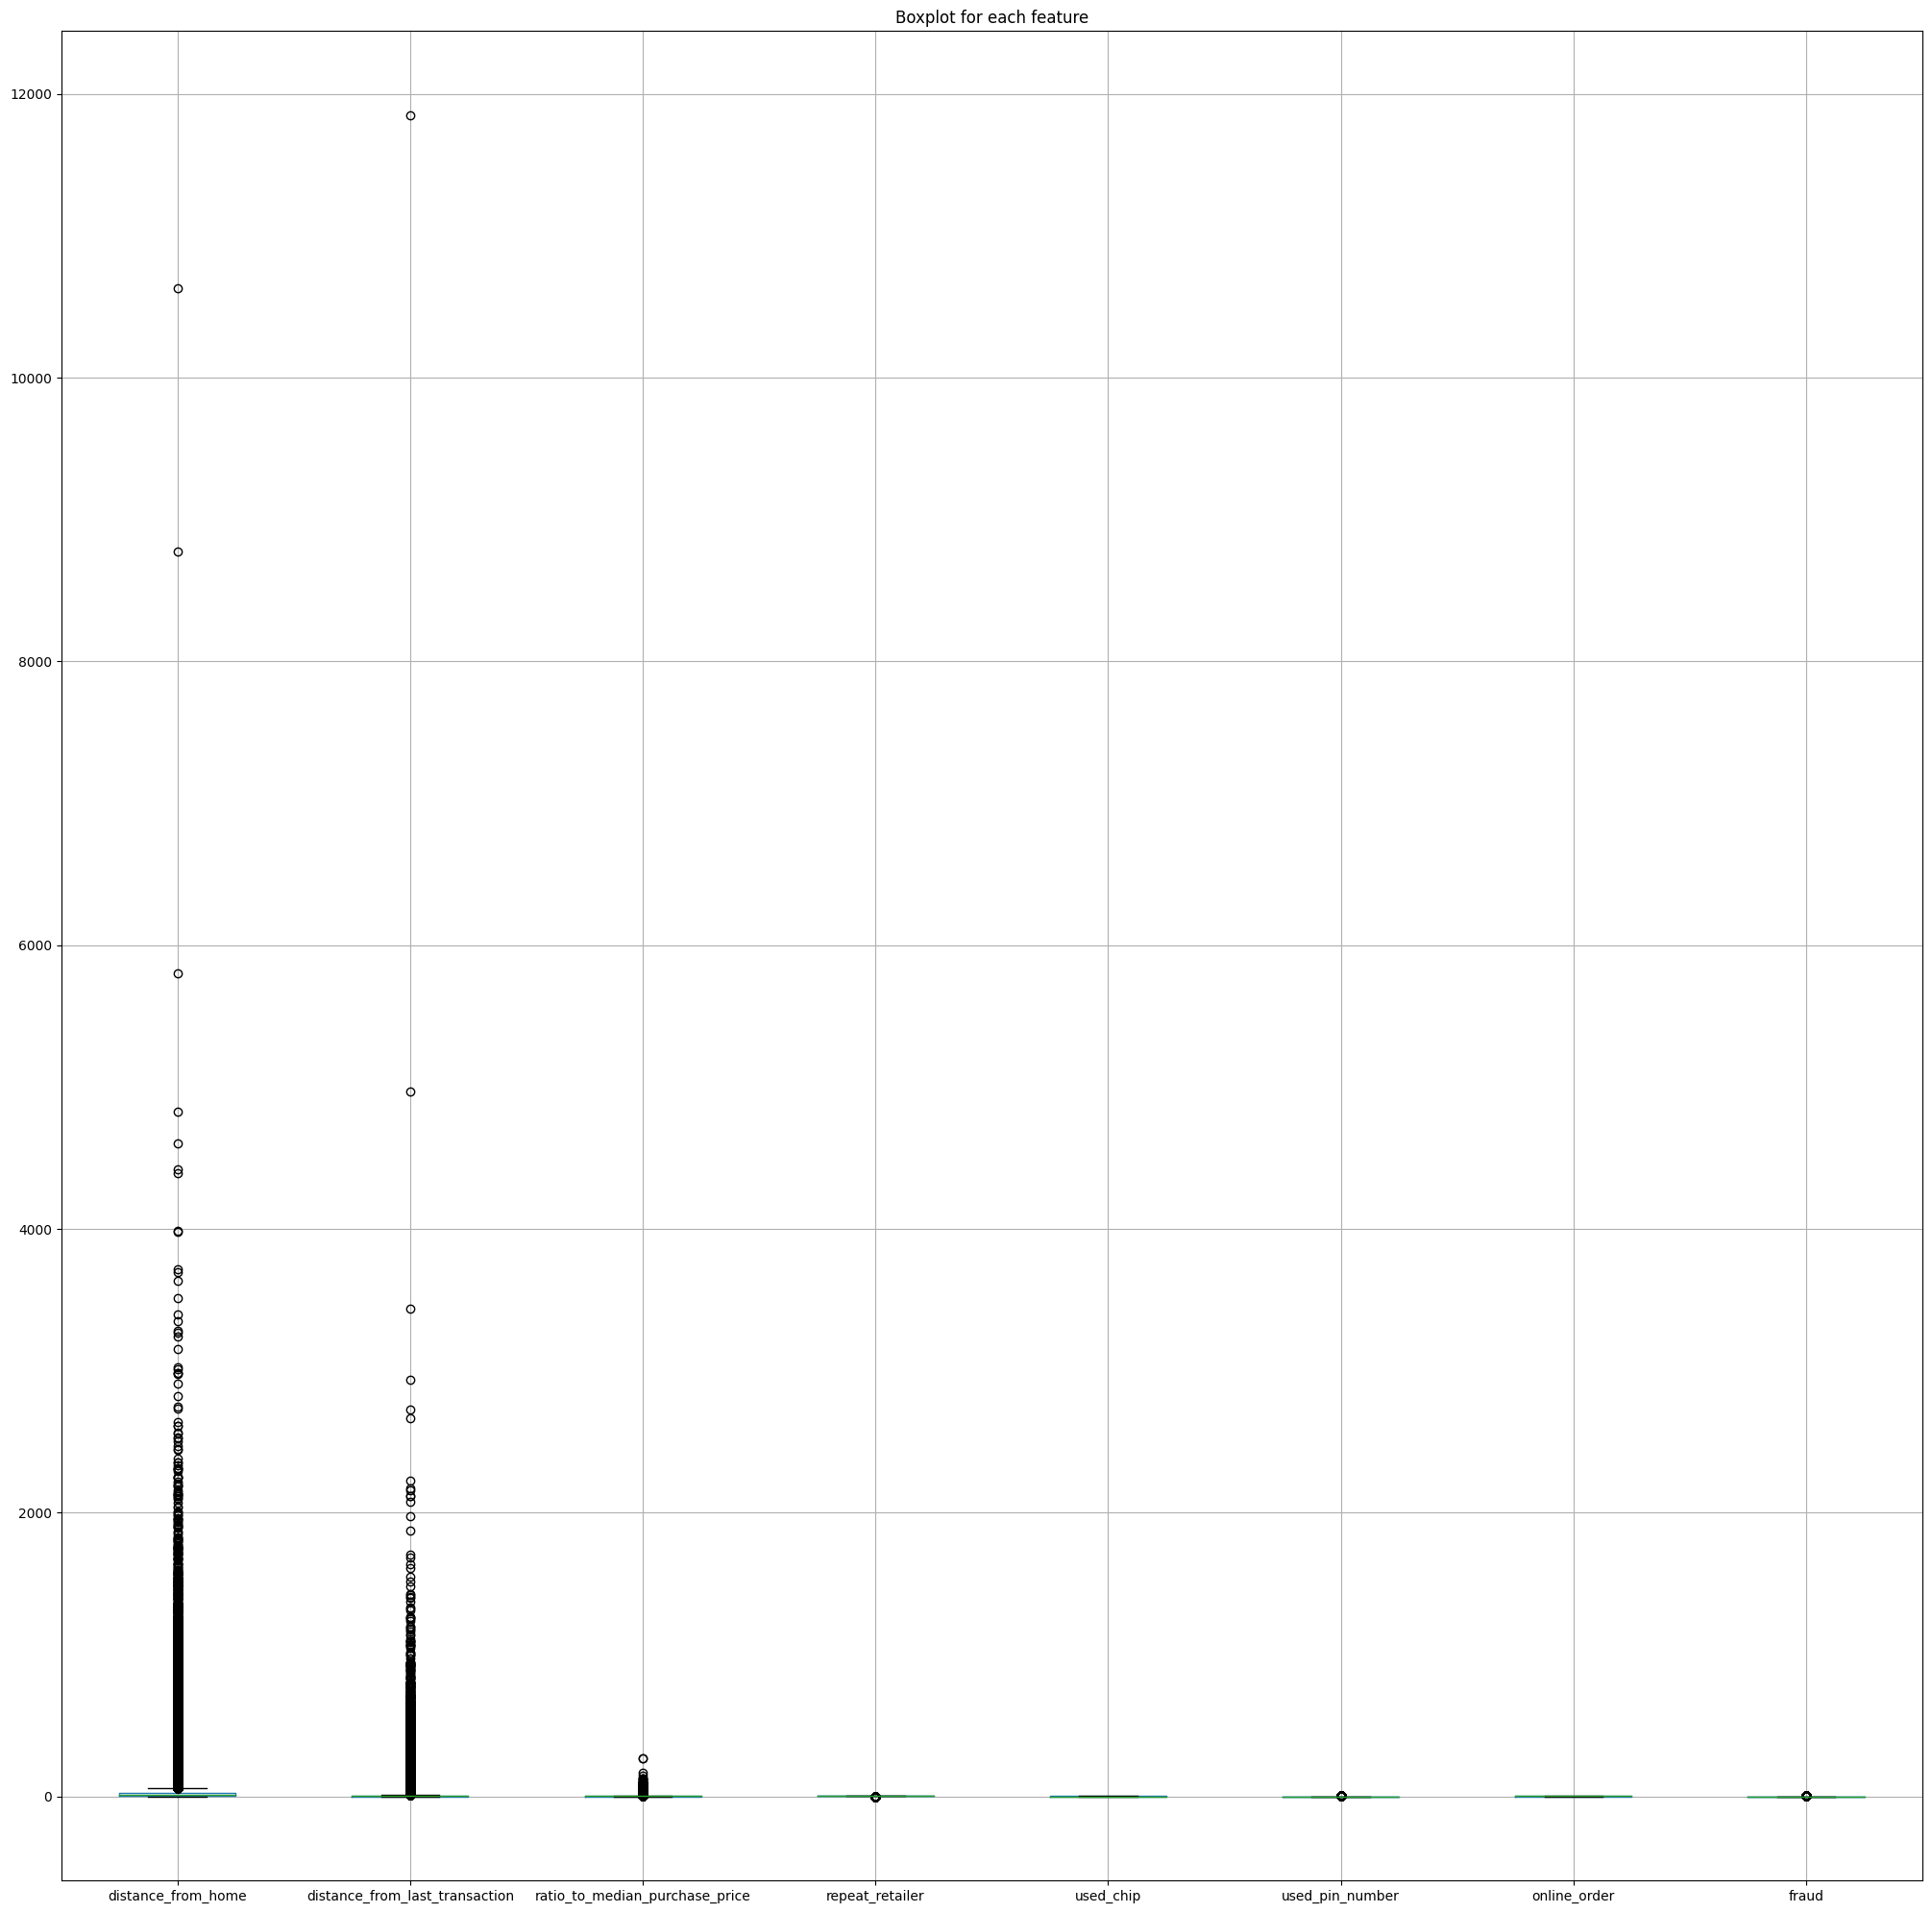

In [10]:
df.select_dtypes('float').boxplot(figsize=(25,25))
plt.title('Boxplot for each feature')

Our dataset exhibits a large number of outliers and highly skewed data

In [11]:
def IQR_method (df,n,features):

    outlier_list = []
    
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        outlier_list.extend(outlier_list_column)
        
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [12]:
Outliers_IQR = IQR_method(df,1,columns)
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 87403


In [13]:
print ('The amount of frauds in df before dropping outliers: ', len(df[df['fraud'] == 1]))
print ('The amount of frauds in df after dropping outliers: ', len(df_out[df_out['fraud'] == 1]))

The amount of frauds in df before dropping outliers:  87403
The amount of frauds in df after dropping outliers:  7554


By dropping the outliers, there will only be 8% of the data remaining! By this case we won't be dropping any outliers .

### Check distribution for each features

/var/folders/wk/1__f0f457zs4shb5sgjd_4x40000gn/T/ipykernel_36838/1413517058.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


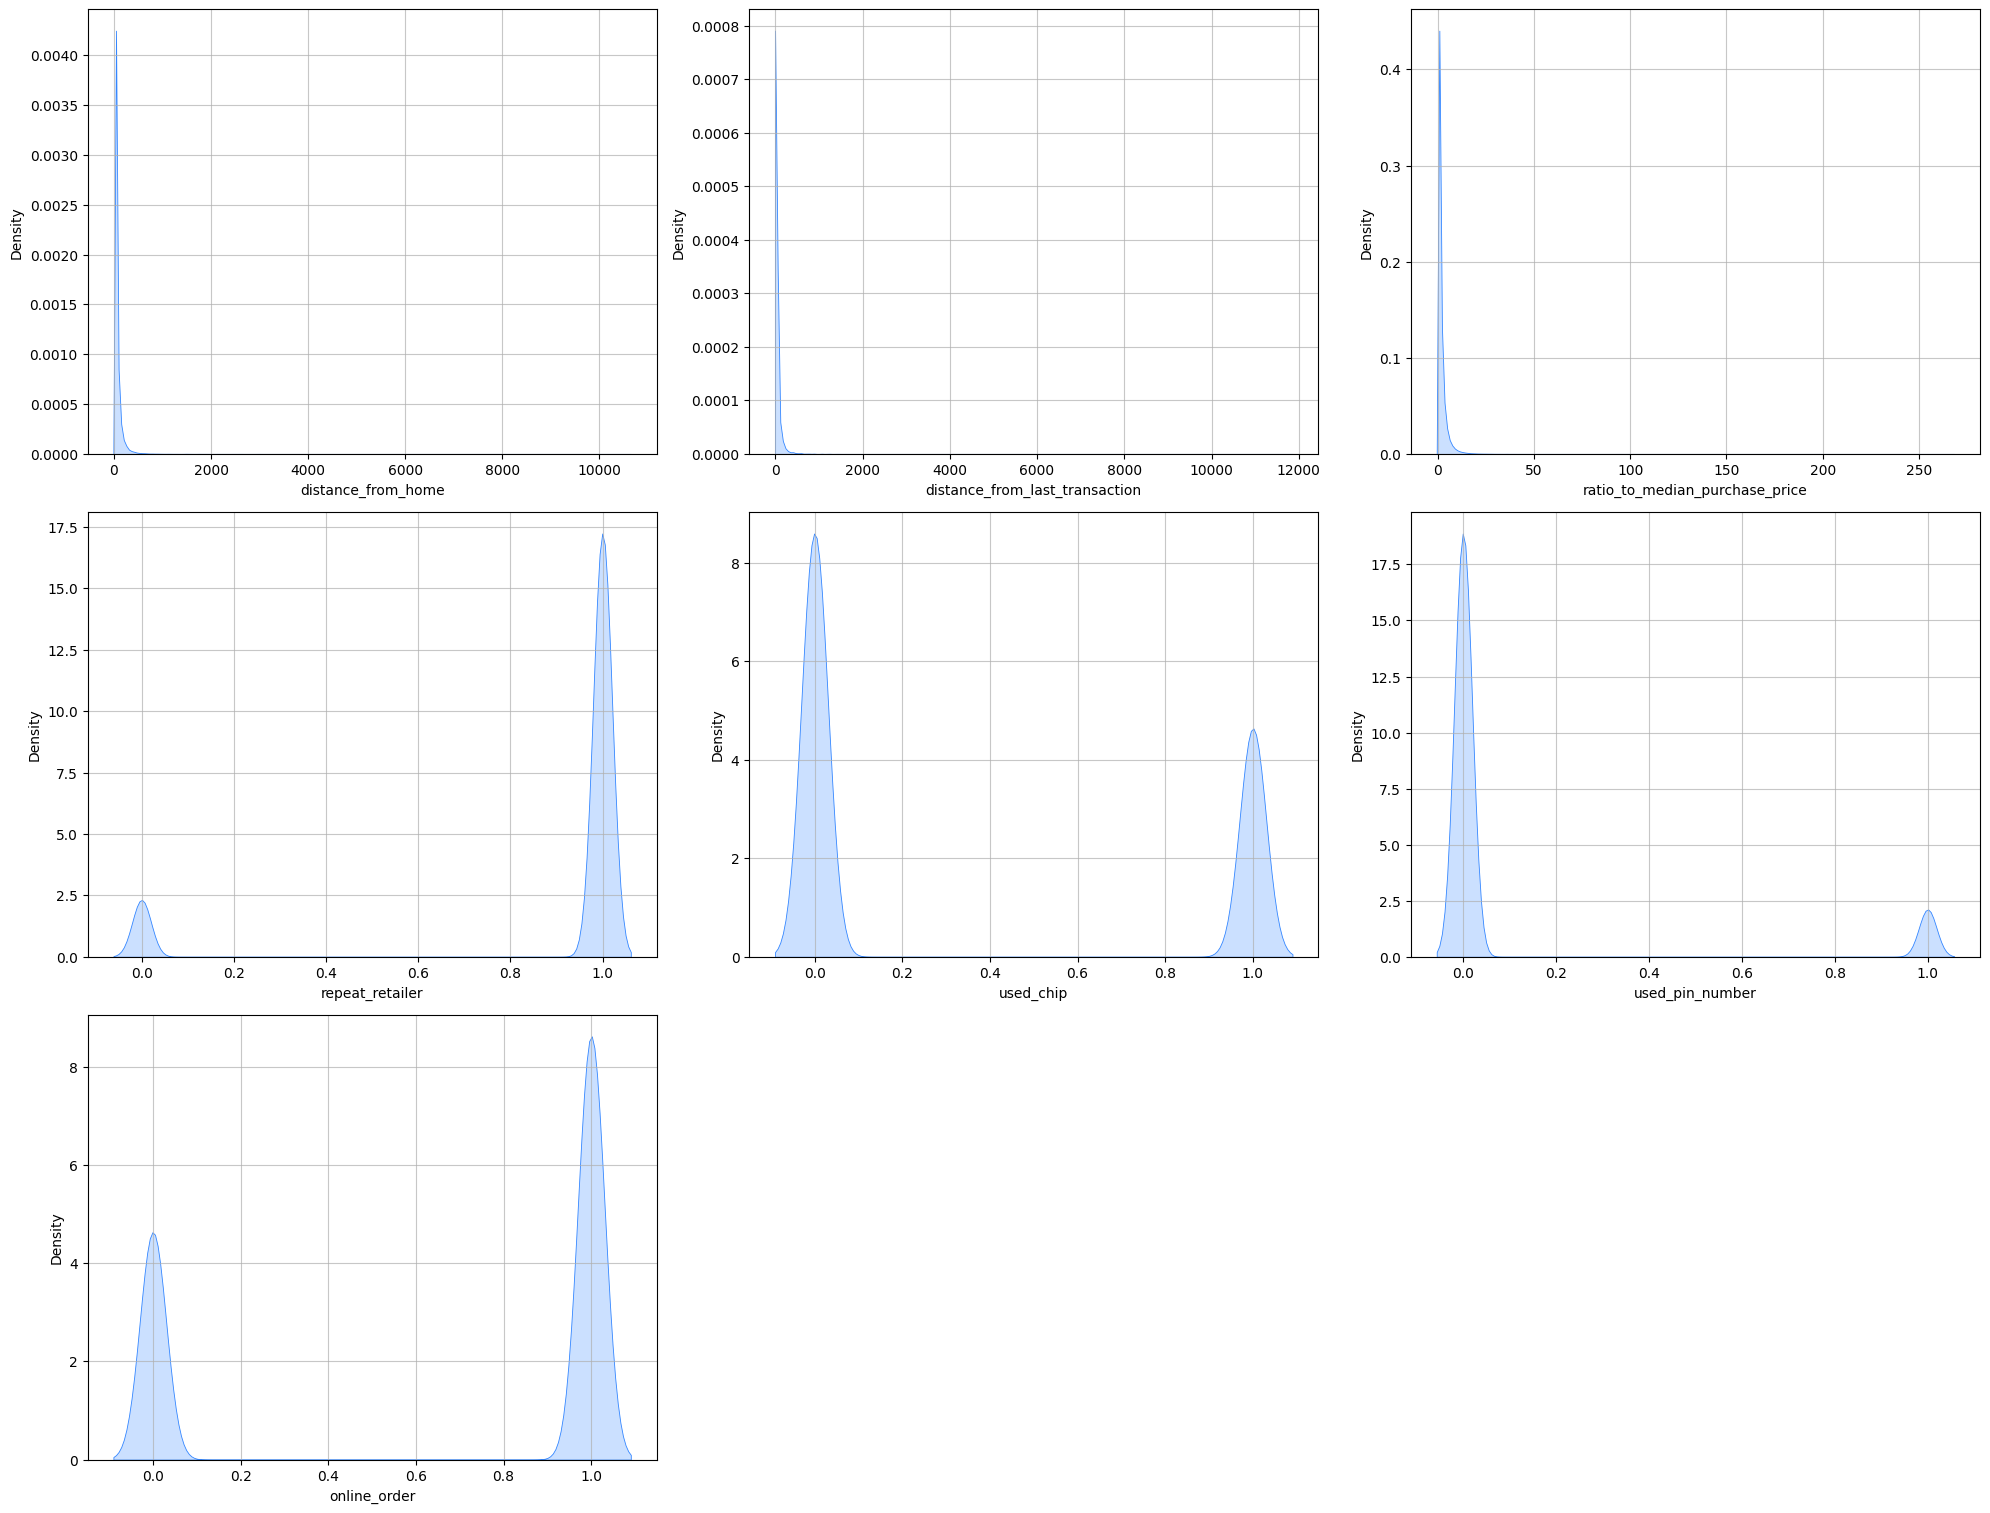

In [14]:
fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3
for idx, num in enumerate(columns[:-1]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.kdeplot(x = num, fill = True,color ="#3386FF",linewidth=0.6, data = df) 
    ax.set_xlabel(num)
fig.tight_layout()
fig.show()

This graph reveals that 'distance_from_home', 'distance_from_last_transaction', and 'ratio_to_median_purchase_price' exhibit left-skewed distributions, while all other features are characterized by non-symmetric bimodal distributions. These findings suggest that appropriate data transformations or non-parametric modeling techniques may be required to account for the non-normality of the data.

### Correlations

In [15]:
plt.figure(figsize=(20,20))
corr=df.corr().round(1)
fig = px.imshow(corr)
fig.update_layout(
    title_text='Features correlation Heatmap'
)
fig.show()

<Figure size 2000x2000 with 0 Axes>

The plot reveals that 'ratio_to_median_purchase_price' has the strongest positive correlation with the target class in our credit card fraud dataset. Additionally, 'online_order' and 'distance_from_home' exhibit the second-highest positive correlation, indicating their potential usefulness in detecting fraudulent transactions.

At the same time, 'used_chip' and 'used_pin_number' both feature negative correlates with the target class, suggesting that their absence may signal a higher likelihood of fraud.

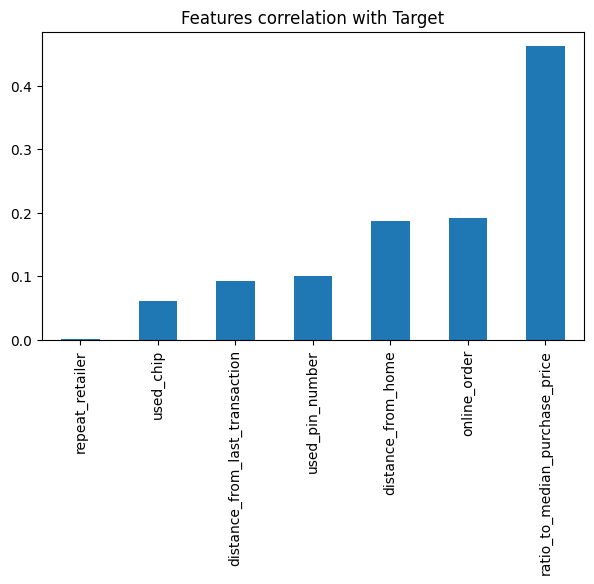

In [16]:
plt.figure(figsize=(7,4))
d = df.corr()['fraud'][:-1].abs().sort_values().plot(kind='bar', title='Features correlation with Target')

### More visulation 

<Figure size 1000x1000 with 0 Axes>

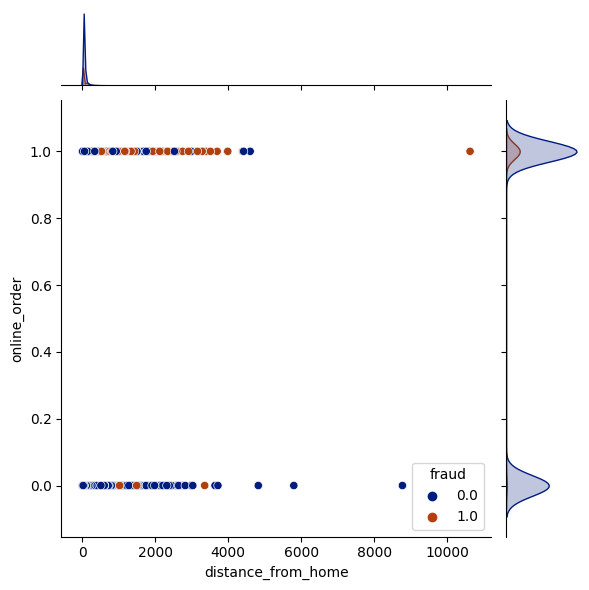

In [17]:
plt.figure(figsize=(10,10))
sns.jointplot(x='distance_from_home', y='online_order',hue='fraud', data=df, palette='dark')

<Figure size 1000x1000 with 0 Axes>

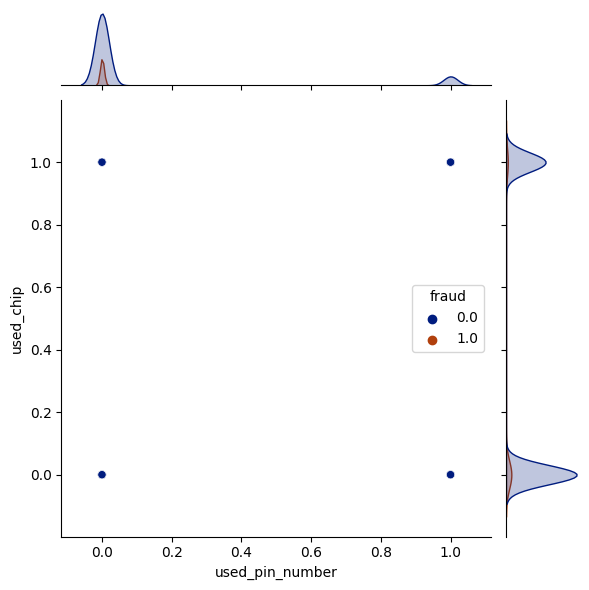

In [18]:
plt.figure(figsize=(10,10))
sns.jointplot(x='used_pin_number', y='used_chip',hue='fraud', data=df, palette='dark')

<hr>

### Undersampling with TomekLinks

In [19]:
from pycaret.classification import *

In [20]:
## take some sample of the date
card_df = df.sample(frac=0.1, random_state=42)
card_df.shape

(100000, 8)

In [21]:
normal = card_df[card_df['fraud'] == 0]
fraud = card_df[card_df['fraud'] == 1]

In [22]:
print(normal.shape, fraud.shape)

(91297, 8) (8703, 8)


In [23]:
exp1 = setup(data=card_df, target='fraud', session_id=123, use_gpu=True, fix_imbalance = True, fix_imbalance_method=TomekLinks())

,Description,Value
0,Session id,123
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(100000, 8)"
4,Transformed data shape,"(99544, 8)"
5,Transformed train set shape,"(69544, 8)"
6,Transformed test set shape,"(30000, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [24]:
exp1.models()

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [25]:
top3 = compare_models(
    turbo=False,
    n_select=3, 
    sort='AUC',
    exclude=['rbfsvm', 'gpc', 'mlp']
    )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9998,1.0000,0.9984,0.9998,0.9991,0.9990,0.9990,0.8380
et,Extra Trees Classifier,0.9980,1.0000,0.9826,0.9945,0.9885,0.9874,0.9875,0.5680
lightgbm,Light Gradient Boosting Machine,0.9978,1.0000,0.9879,0.9874,0.9876,0.9864,0.9864,3.1450
ada,Ada Boost Classifier,0.9998,0.9999,0.9980,0.9992,0.9986,0.9985,0.9985,1.8610
gbc,Gradient Boosting Classifier,0.9995,0.9999,0.9959,0.9987,0.9973,0.9970,0.9970,6.4570
dt,Decision Tree Classifier,0.9997,0.9990,0.9982,0.9985,0.9984,0.9982,0.9982,0.1310
knn,K Neighbors Classifier,0.9620,0.9783,0.8250,0.7595,0.7908,0.7700,0.7708,0.7200
lda,Linear Discriminant Analysis,0.9376,0.9710,0.4156,0.7579,0.5366,0.5062,0.5327,0.1650
lr,Logistic Regression,0.9601,0.9706,0.6307,0.8768,0.7335,0.7126,0.7240,0.4330
qda,Quadratic Discriminant Analysis,0.9512,0.9659,0.6310,0.7669,0.6921,0.6659,0.6697,0.1200


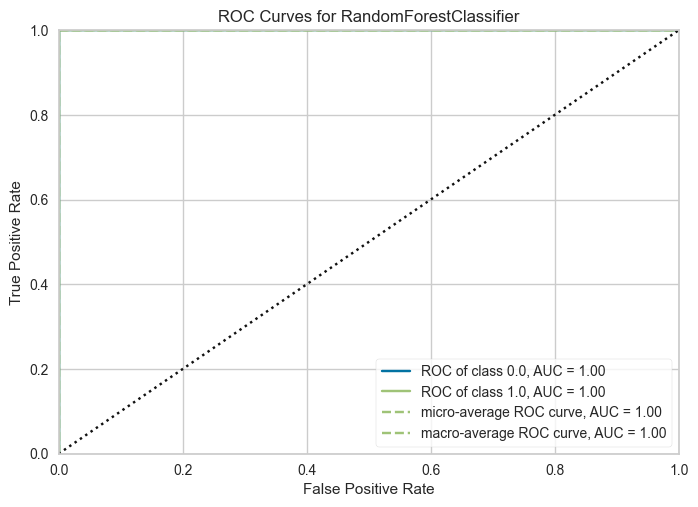

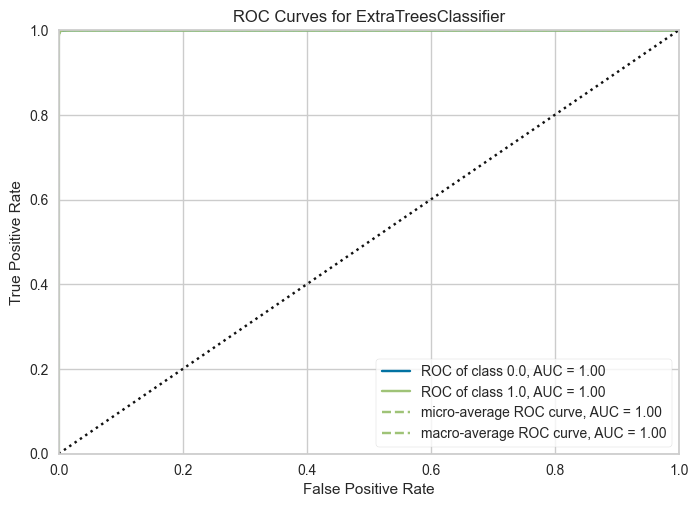

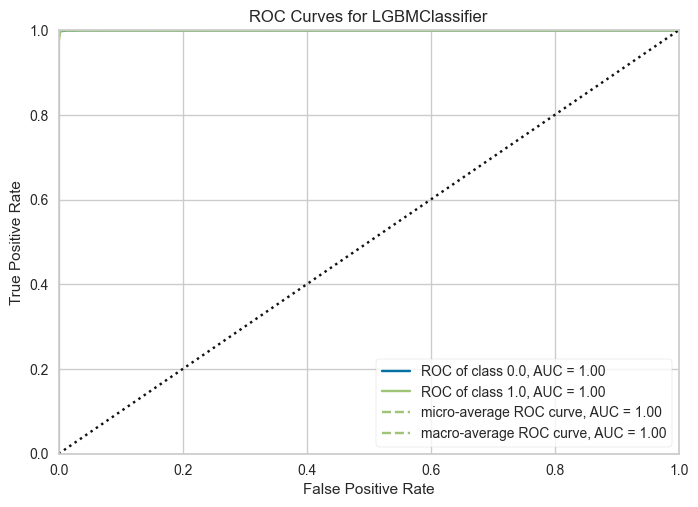

In [26]:
for model in top3:
    exp1.plot_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9999,1.0000,1.0000,0.9984,0.9992,0.9991,0.9991
1,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
2,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
8,0.9991,1.0000,0.9902,1.0000,0.9951,0.9946,0.9946


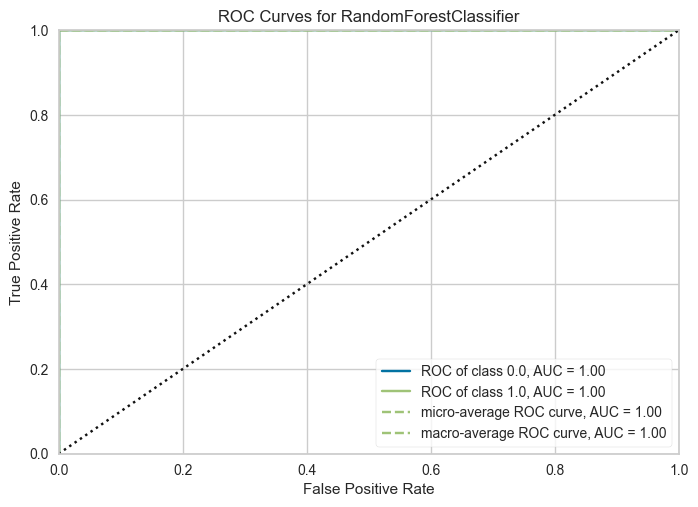

In [27]:
rf = exp1.create_model('rf')
plot_model(rf)

In [28]:
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_rf

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9694,1.0000,1.0000,0.7400,0.8506,0.8340,0.8457
1,0.9701,1.0000,1.0000,0.7445,0.8535,0.8373,0.8486
2,0.9717,0.9998,0.9967,0.7559,0.8598,0.8444,0.8544
3,0.9699,1.0000,1.0000,0.7427,0.8523,0.8360,0.8474
4,0.9721,0.9998,0.9967,0.7588,0.8616,0.8464,0.8562
5,0.9671,0.9999,0.9984,0.7264,0.8409,0.8231,0.8361
6,0.9663,1.0000,1.0000,0.7207,0.8377,0.8194,0.8331
7,0.9680,0.9999,0.9984,0.7316,0.8444,0.8271,0.8395
8,0.9707,0.9998,0.9967,0.7497,0.8557,0.8398,0.8504


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

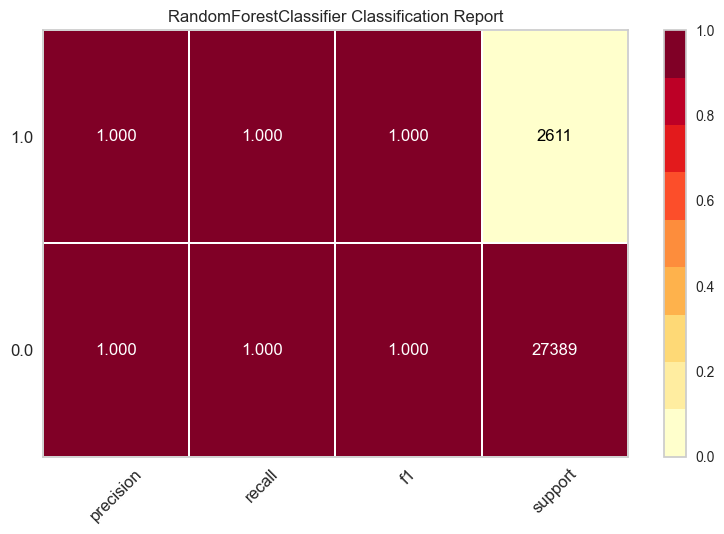

In [29]:
plot_model(tuned_rf, plot='class_report')

<hr>

### Oversampling with SMOTE

In [30]:
exp2 = setup(data=card_df, target='fraud', session_id=123, use_gpu=True, fix_imbalance = True, fix_imbalance_method=SMOTE())

,Description,Value
0,Session id,123
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(100000, 8)"
4,Transformed data shape,"(157816, 8)"
5,Transformed train set shape,"(127816, 8)"
6,Transformed test set shape,"(30000, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [31]:
exp2.models()

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [32]:
over_top3 = compare_models(
    turbo=False,
    n_select=3, 
    sort='AUC',
    exclude=['rbfsvm', 'gpc', 'mlp']
    )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9997,1.0000,0.9979,0.9990,0.9984,0.9983,0.9983,1.4310
ada,Ada Boost Classifier,0.9993,1.0000,0.9989,0.9932,0.9960,0.9956,0.9956,3.4390
lightgbm,Light Gradient Boosting Machine,0.9988,1.0000,0.9949,0.9918,0.9934,0.9927,0.9927,3.2750
gbc,Gradient Boosting Classifier,0.9989,0.9999,0.9934,0.9941,0.9938,0.9932,0.9932,12.4690
et,Extra Trees Classifier,0.9983,0.9999,0.9902,0.9907,0.9904,0.9895,0.9895,0.8460
dt,Decision Tree Classifier,0.9996,0.9990,0.9982,0.9977,0.9979,0.9978,0.9978,0.2860
lr,Logistic Regression,0.9359,0.9798,0.9463,0.5808,0.7198,0.6859,0.7120,0.6800
knn,K Neighbors Classifier,0.9476,0.9798,0.9616,0.6308,0.7617,0.7338,0.7544,0.6330
lda,Linear Discriminant Analysis,0.9005,0.9666,0.9342,0.4649,0.6206,0.5707,0.6170,0.2340
qda,Quadratic Discriminant Analysis,0.8159,0.9632,0.9606,0.3296,0.4876,0.4105,0.4971,0.1750


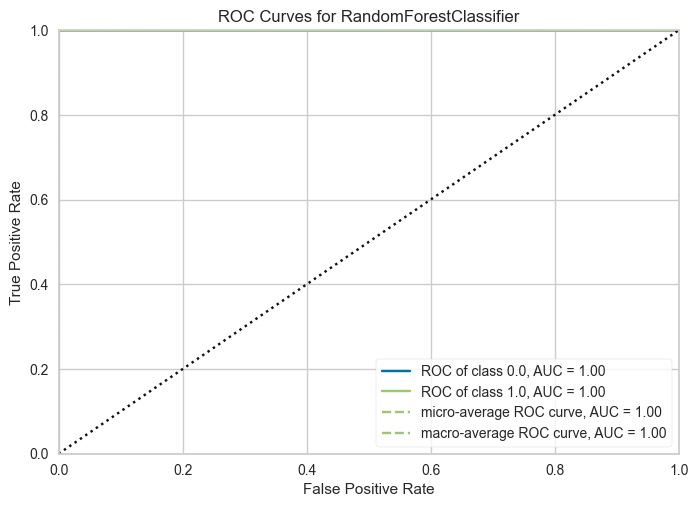

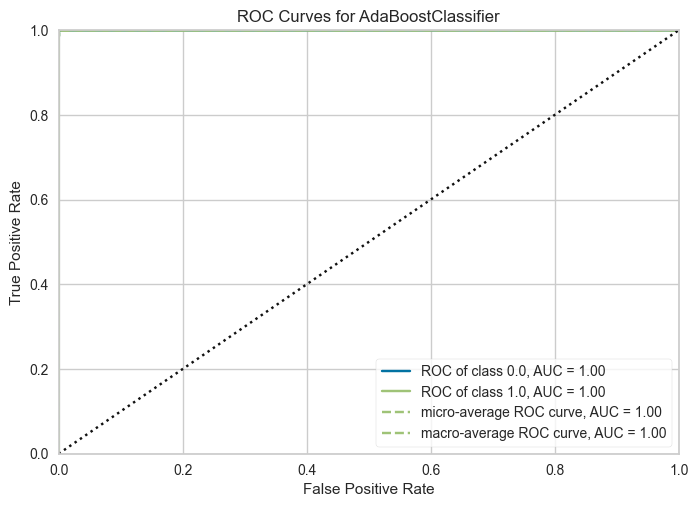

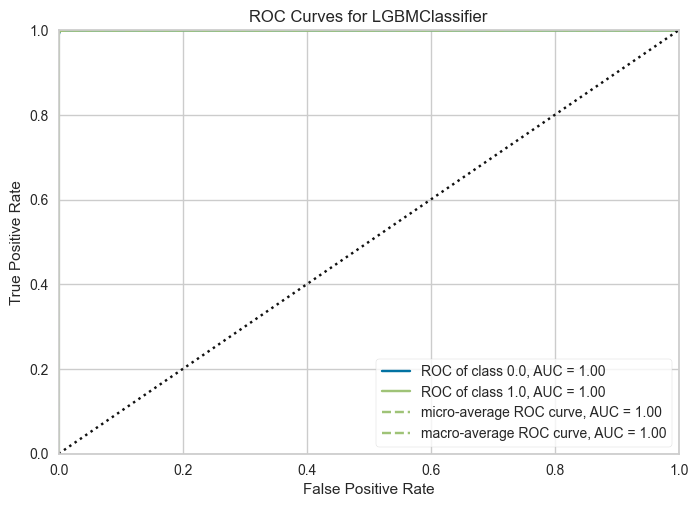

In [33]:
for model in over_top3:
    exp1.plot_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9999,1.0000,1.0000,0.9984,0.9992,0.9991,0.9991
1,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
2,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9999,1.0000,0.9984,1.0000,0.9992,0.9991,0.9991
8,0.9991,1.0000,0.9902,1.0000,0.9951,0.9946,0.9946


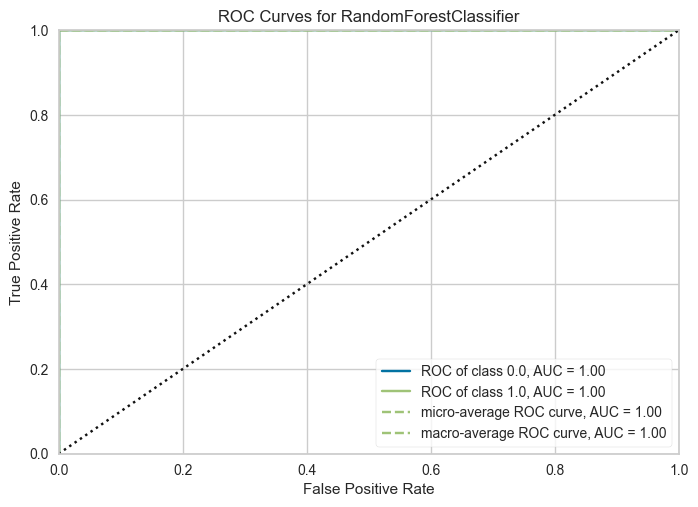

In [34]:
over_rf = exp1.create_model('rf')
plot_model(over_rf)

In [35]:
tuned_over_rf = tune_model(over_rf, optimize = 'AUC')
tuned_over_rf

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9997,1.0000,0.9967,1.0000,0.9984,0.9982,0.9982
1,0.9991,0.9999,0.9918,0.9983,0.9951,0.9946,0.9946
2,0.9974,0.9998,0.9704,1.0000,0.9850,0.9836,0.9837
3,0.9989,0.9998,0.9869,1.0000,0.9934,0.9928,0.9928
4,0.9980,0.9998,0.9770,1.0000,0.9884,0.9873,0.9874
5,0.9989,0.9998,0.9869,1.0000,0.9934,0.9928,0.9928
6,0.9989,0.9999,0.9869,1.0000,0.9934,0.9928,0.9928
7,0.9983,0.9999,0.9819,0.9983,0.9901,0.9891,0.9892
8,0.9986,0.9999,0.9836,1.0000,0.9917,0.9910,0.9910


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

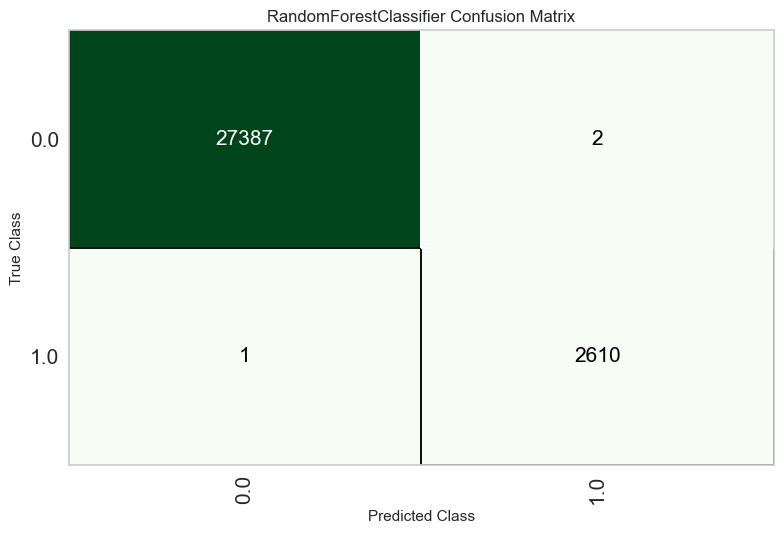

In [36]:
plot_model(tuned_over_rf, plot='confusion_matrix')

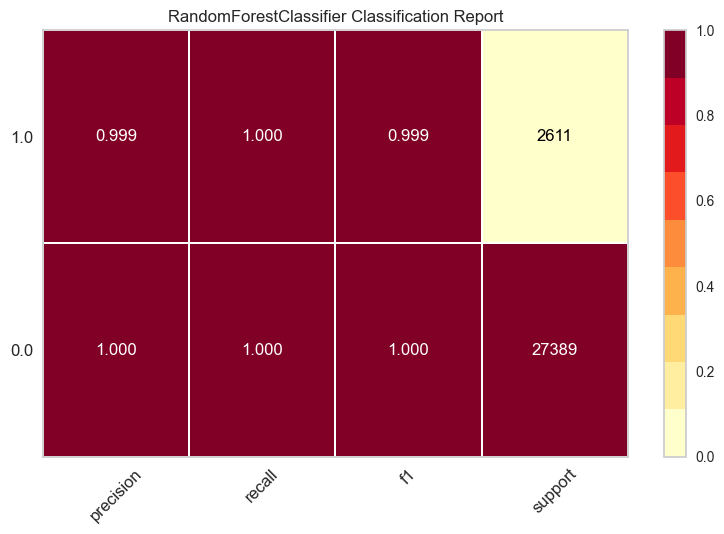

In [37]:
plot_model(tuned_over_rf, plot='class_report')

<hr>

### Model Prediction 

In [38]:
predict_model(tuned_rf, drift_report = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9999,1.0000,0.9996,0.9996,0.9996,0.9996,0.9996


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,prediction_label,prediction_score
70000,6.909158,0.933142,0.820499,1.0,0.0,0.0,0.0,0.0,0,1.0
70001,13.939906,0.256164,1.880343,1.0,0.0,0.0,1.0,0.0,0,1.0
70002,14.488329,0.625091,0.372755,1.0,0.0,0.0,0.0,0.0,0,1.0
70003,50.838249,1.560997,1.884427,1.0,0.0,0.0,1.0,0.0,0,1.0
70004,1.138101,12.077786,1.884369,0.0,0.0,0.0,1.0,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
99995,6.303906,9.316354,1.511074,1.0,0.0,0.0,1.0,0.0,0,1.0
99996,0.340415,0.784275,0.240530,0.0,0.0,0.0,0.0,0.0,0,1.0
99997,12.820970,1.145884,0.788746,1.0,0.0,0.0,1.0,0.0,0,1.0
99998,30.640533,0.402421,2.851121,1.0,0.0,0.0,0.0,0.0,0,1.0


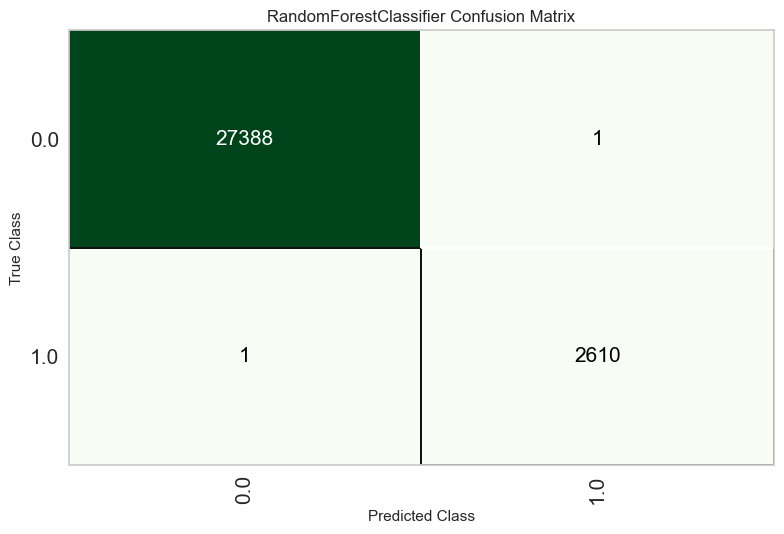

In [39]:
plot_model(tuned_rf, plot='confusion_matrix')

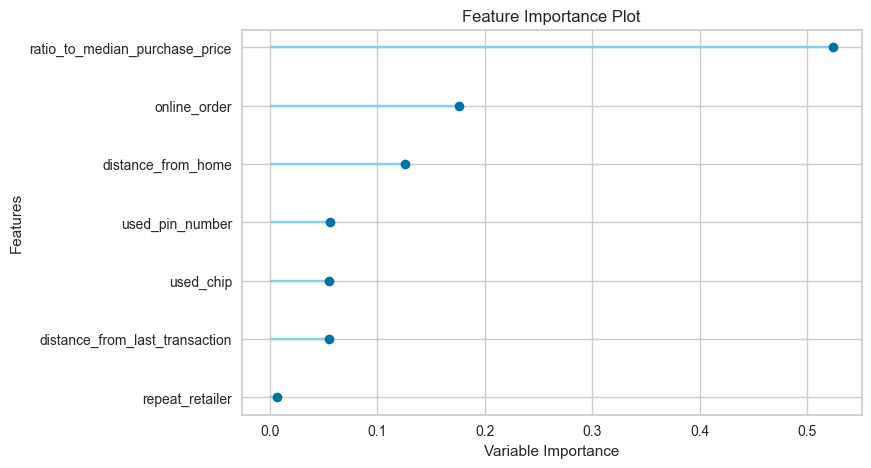

In [40]:
plot_model(tuned_rf, plot='feature')

In [41]:
predict_model(tuned_over_rf, drift_report = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9999,1.0000,0.9996,0.9992,0.9994,0.9994,0.9994


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,prediction_label,prediction_score
70000,6.909158,0.933142,0.820499,1.0,0.0,0.0,0.0,0.0,0,1.0
70001,13.939906,0.256164,1.880343,1.0,0.0,0.0,1.0,0.0,0,1.0
70002,14.488329,0.625091,0.372755,1.0,0.0,0.0,0.0,0.0,0,1.0
70003,50.838249,1.560997,1.884427,1.0,0.0,0.0,1.0,0.0,0,1.0
70004,1.138101,12.077786,1.884369,0.0,0.0,0.0,1.0,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
99995,6.303906,9.316354,1.511074,1.0,0.0,0.0,1.0,0.0,0,1.0
99996,0.340415,0.784275,0.240530,0.0,0.0,0.0,0.0,0.0,0,1.0
99997,12.820970,1.145884,0.788746,1.0,0.0,0.0,1.0,0.0,0,1.0
99998,30.640533,0.402421,2.851121,1.0,0.0,0.0,0.0,0.0,0,1.0


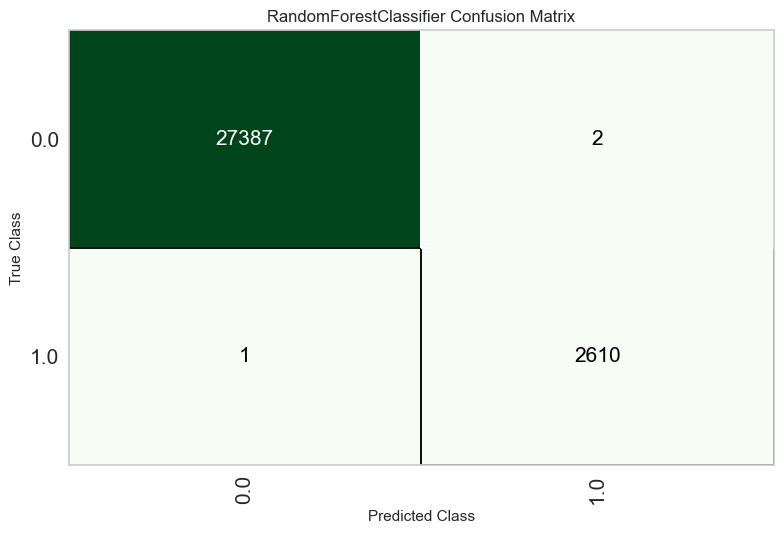

In [42]:
plot_model(tuned_over_rf, plot='confusion_matrix')

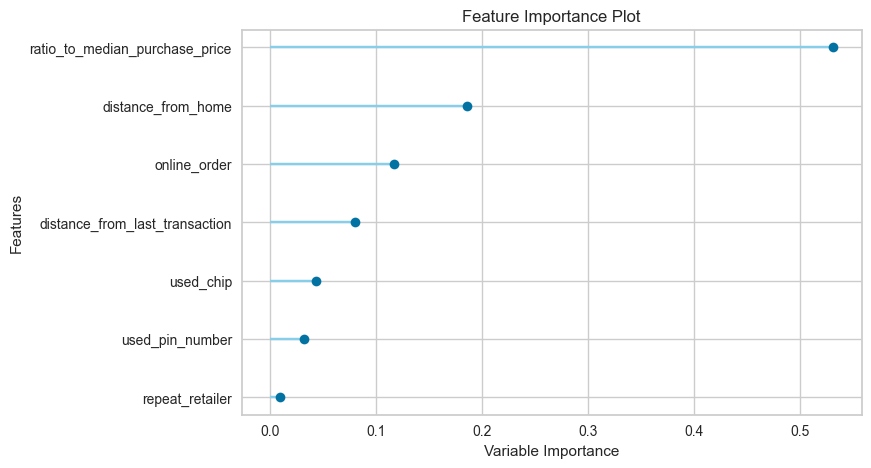

In [43]:
plot_model(tuned_over_rf, plot='feature')